In [1]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp

import yaml

from qubic.lib.MapMaking.Qatmosphere import AtmosphereMaps, WindPerturbation
from qubic.lib.Instrument.Qinstrument import compute_freq

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


In [2]:
params = yaml.safe_load(open("params.yml", "r"))   # absolute path for the params.yml file

params['sigma_wv'] = 0.52 #mm, Sugiyama 2024

Atmosphere = AtmosphereMaps(params)

Wind = WindPerturbation(params, npointings = 100)

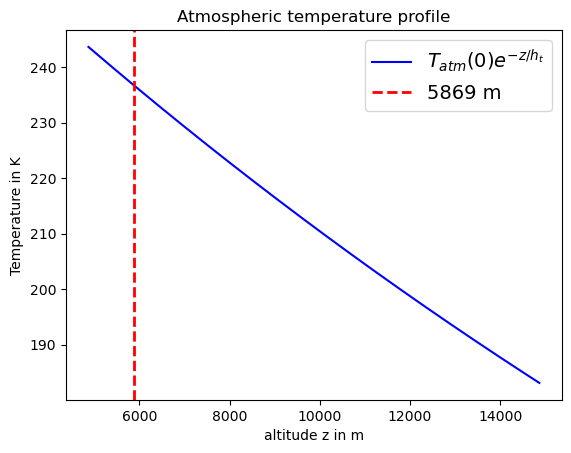

In [3]:
# Ploting the atmospheric temperature distribution

altitude = params["h_qubic"] + params["altitude_atm_2d"] * np.ones(params["h_grid"])
z = np.linspace(0,10000,10000) + params['h_qubic']
temperature =  Atmosphere.get_temperature_atm(z, params["temp_ground"], params["h_temp"])   
#temperature = params["temp_ground"] * np.exp(-z / params["h_temp"])

plt.plot(z,temperature, color='blue', label = r"$T_{atm}(0)e^{-z/h_t}$")
plt.axvline(x=altitude, color='red', linestyle='--', linewidth=2,label =f'{int(altitude)} m')
plt.xlabel('altitude z in m')
plt.ylabel('Temperature in K')        
plt.title('Atmospheric temperature profile')
plt.legend(fontsize =14)                      

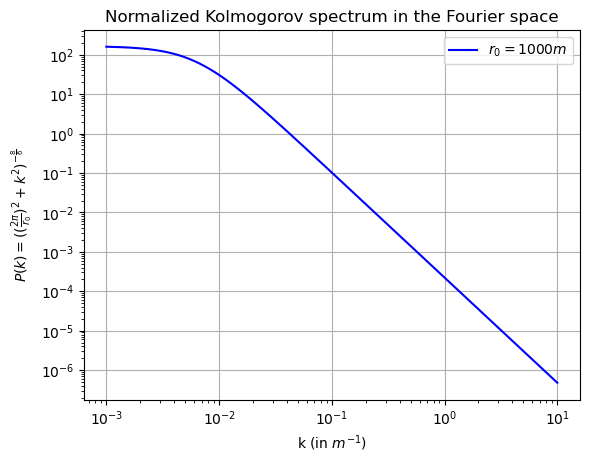

In [4]:
# Ploting the normalized 1D Kolmogorov spectrum with r0 \approx 1000 m (Morris 2021)

Klin = np.linspace(0,100,1000) #using linear distribution
Klog = np.logspace(-3,1,1000) #using logarithmic distribution 

Kolm_lin= Atmosphere.normalized_kolmogorov_spectrum(Klin, r0=100)
Kolm_log= Atmosphere.normalized_kolmogorov_spectrum(Klog, r0=1000)

# Turns out log distrib suits best

plt.yscale('log')
plt.xscale('log')
plt.xlabel('k (in $m^{-1}$)')
plt.ylabel(r"$P(k)=((\frac{2 \pi}{r_0})^2 + k^2)^{- \frac{8}{6}}$")
plt.title("Normalized Kolmogorov spectrum in the Fourier space")


plt.plot(Klog,Kolm_log, label = r"$r_0 = 1000 m$", color='blue')
plt.grid()
plt.legend(loc = "upper right")

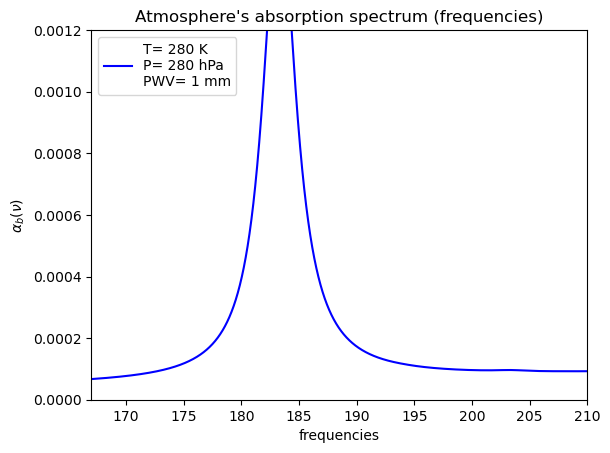

In [5]:
# Ploting the atmosphere's absorption spectrum from AtmosphereProperties

nus = Atmosphere.atm_absorption_coeff()[-1] # this function gives all coeffs used by absorption_spectrum, but it also last gives an array of the considered frequencies .
# It's all taken from the absorption_coefficient file . This variable self.atm_absorption_coeff()[-1] is also used as self.integrated_frequencies in the script
Spectre = Atmosphere.absorption_spectrum() 

plt.xlim(167,210) #close to QUBIC's actual window
plt.ylim(0, .0012)
plt.xlabel('frequencies')
plt.ylabel(r'$\alpha_b(\nu)$')
plt.title("Atmosphere's absorption spectrum (frequencies)")

plt.plot(nus,Spectre ,color='blue', label= f'T= {params["temp_ground"]} K \nP= {params["temp_ground"]} hPa \nPWV= {params["pwv"]} mm')
plt.legend(loc='upper left')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


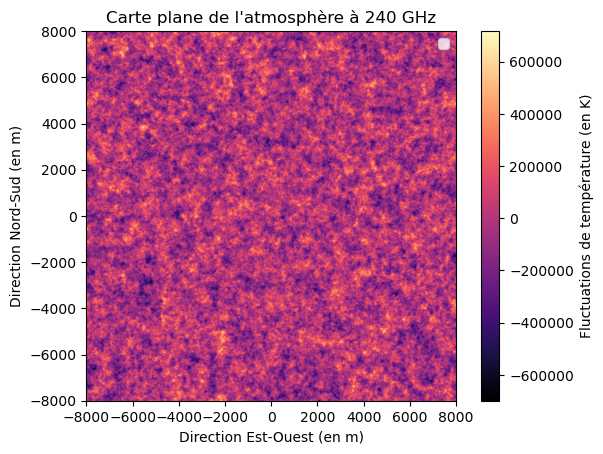

In [6]:
# Ploting the temperature map using  the function get_temp_map and the fourier space


maps_flat = Atmosphere.get_water_vapor_density_fluctuation_2d_map() #default : flat=True so it uses the fourier spatial fluctuations
#returns (1000,1000) 2d array 


temp_maps_flat = Atmosphere.get_temp_maps(maps_flat) #returns 3d array shaped (8,1000,1000)


## here, 8 = params['nsub_in'] is the Number of sub-acquisitions used to integrate over the atm spectrum. To plot either of the two temp_maps, fix one of the 8 frequencies and plot the rest of the array
## for temp_maps_flat, use imshow() at a given frequency (thus it plots a (1000,1000) array); for temp_maps_curved, use hp.mollview on the (196608,) shaped array.

eight_frequencies = Atmosphere.frequencies
size_atm = params['size_atm']

##Ploting a single map

plt.imshow(temp_maps_flat[-1] , origin ='lower', cmap = 'magma', extent =(-size_atm , size_atm , -size_atm , size_atm))
plt.xlabel('Direction Est-Ouest (en m)')
plt.ylabel('Direction Nord-Sud (en m)')
plt.title(f"Carte plane de l'atmosphère à {round(eight_frequencies[-1])} GHz")
plt.colorbar(label=r'Fluctuations de température (en K)')
plt.legend()
plt.show()

##Ploting all 8 maps in a row

# for i in range(8):
#     plt.imshow(temp_maps_flat[i] , origin ='lower', cmap = 'magma', extent =(-size_atm , size_atm , -size_atm , size_atm))
#     plt.title(f"Temperature map at {round(eight_frequencies[i])} GHz")
#     plt.colorbar(label=r'Temperature fluctuations in $\mu K$')
#     plt.legend()
#     plt.show()

# ##Ploting several maps in one plot

# fig, axs = plt.subplots(2, 2, figsize=(8, 6))

# # Sub-figure 1
# im1 = axs[0, 0].imshow(temp_maps_flat[0], cmap='magma', extent =(-size_atm , size_atm , -size_atm , size_atm), origin ='lower')
# axs[0, 0].set_title(f"Temperature map at {round(eight_frequencies[0])} GHz")
# plt.colorbar(im1, ax=axs[0, 0])

# # Sub-figure 2
# im2 = axs[0, 1].imshow(temp_maps_flat[2], cmap='magma', extent =(-size_atm , size_atm , -size_atm , size_atm))
# axs[0, 1].set_title(f"Temperature map at {round(eight_frequencies[2])} GHz")
# plt.colorbar(im2, ax=axs[0, 1])

# # Sub-figure 3
# im3 = axs[1, 0].imshow(temp_maps_flat[4], cmap='magma', extent =(-size_atm , size_atm , -size_atm , size_atm))
# axs[1, 0].set_title(f"Temperature map at {round(eight_frequencies[4])} GHz")
# plt.colorbar(im3, ax=axs[1, 0])

# # Sub-figure 4
# im4 = axs[1, 1].imshow(temp_maps_flat[6], cmap='magma', extent =(-size_atm , size_atm , -size_atm , size_atm))
# axs[1, 1].set_title(f"Temperature map at {round(eight_frequencies[6])} GHz")
# plt.colorbar(im4, ax=axs[1, 1])


# # Adjusting their layout
# plt.tight_layout()


# plt.legend()
# plt.show()
## the map isn't changing, but the colorbar is : indeed, in the script the frequency isn't affecting the atmosphere properties like temperature, thus functions generating the map (genereate_spatial_fluctuations,
##kolmogorov_spectrum, etc). The frequency only affects the scale

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


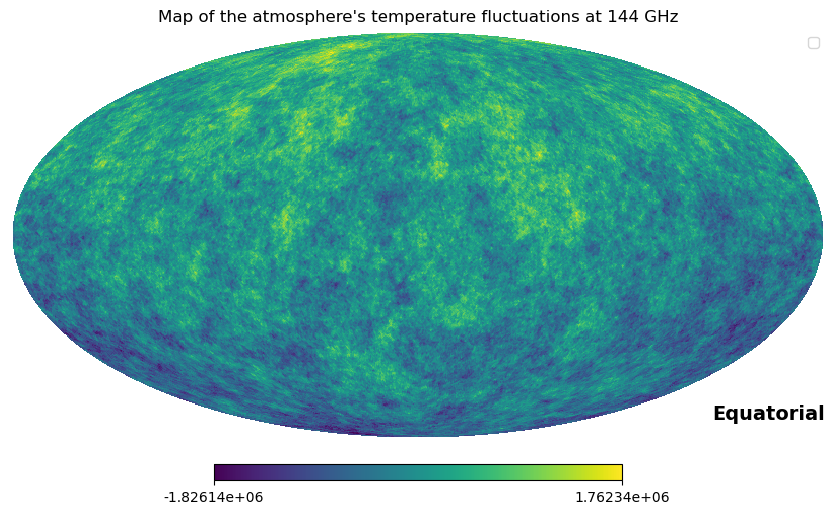

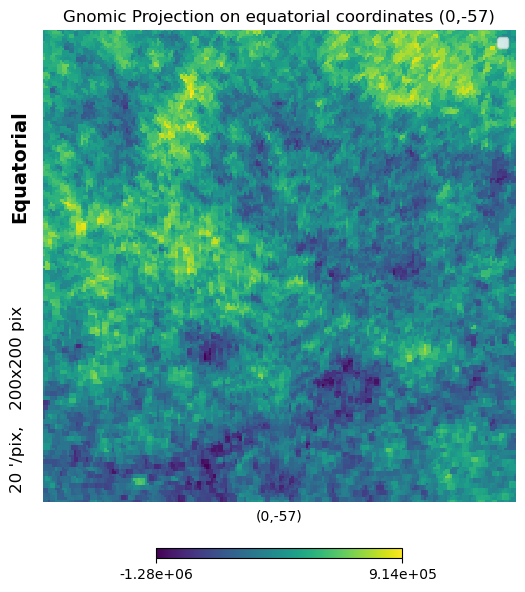

In [7]:
# Ploting the temperature map using  the function get_temp_map and spherical harmonics

maps_curved = Atmosphere.get_water_vapor_density_fluctuation_2d_map(flat= False) # uses the spherical harmonics
#returns 1d array shaped (196608,)

temp_maps_curved = Atmosphere.get_temp_maps(maps_curved) #returns 2d array shaped (8,196608)


eight_frequencies = Atmosphere.frequencies
hp.mollview(temp_maps_curved[1], coord = 'C')  #coord = 'C' sets the coordinate system to equatorial/celestial

plt.title(f"Map of the atmosphere's temperature fluctuations at {round(eight_frequencies[1])} GHz")
plt.legend() 

hp.gnomview(temp_maps_curved[0],coord = 'C',rot =np.array([Atmosphere.qubic_dict['RA_center' ], Atmosphere.qubic_dict['DEC_center']]),reso =20)   #get a flat focus of the latter mollview map, centered on the celestial coordinates given by the qubic_dict
plt.title(f"Gnomic Projection on equatorial coordinates ({Atmosphere.qubic_dict['RA_center' ]},{Atmosphere.qubic_dict['DEC_center']})")
plt.legend()

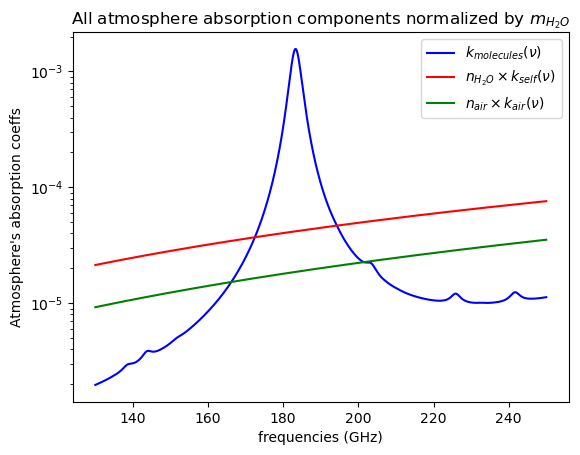

In [8]:
mol_absorption_coeff, self_absorption_coeff, air_absorption_coeff, frequencies = Atmosphere.atm_absorption_coeff()  #getting all three k(\nu) and the frequencies for which we know their values
water_mass, water_vapor_density, air_density = Atmosphere.get_gas_properties()   #getting some air properties used in the \alpha_b(\nu) formula

plt.yscale('log')
plt.xlabel('frequencies (GHz)')
plt.ylabel("Atmosphere's absorption coeffs")
plt.title(r"All atmosphere absorption components normalized by $m_{H_2O}$")

plt.plot(frequencies, mol_absorption_coeff / water_mass, color = 'blue', label = r"$k_{molecules}(\nu)$")
plt.plot(frequencies, water_vapor_density * self_absorption_coeff / water_mass, color='red', label = r"$ n_{H_2O} \times k_{self}(\nu)$")
plt.plot(frequencies, air_density * air_absorption_coeff / water_mass, color = 'green', label = r"$ n_{air} \times k_{air}(\nu)$")

plt.legend()

In [ ]:
abs_spectrum = Atmosphere.abs_spectrum
frequencies = Atmosphere.integration_frequencies

band = 150

 ### Evaluate the frequency band edges
freq_min, freq_max = frequencies[0], frequencies[-1]
freq_step = (freq_max - freq_min) / (len(frequencies) - 1)

### Compute the frequency sub-bands within the QUBIC band and their associated indexes
_, nus_edges, nus, bandwidths, _, N_bands = compute_freq(band, Nfreq=int(params["nsub_in"] / 2), relative_bandwidth= Atmosphere.qubic_dict["filter_relative_bandwidth"])
nus_edge_index = np.round((nus_edges - freq_min) / freq_step).astype(int)

np.array([np.trapz(abs_spectrum[nus_edge_index[i] : nus_edge_index[i + 1]], x=frequencies[nus_edge_index[i] : nus_edge_index[i + 1]]) / (nus_edges[i + 1] - nus_edges[i]) for i in range(N_bands)])

array([3.57488037e-05, 4.13450291e-05, 4.83062203e-05, 6.07597671e-05])

In [ ]:
# Ploting the scanning strategy adapted to the wind

## Computing the atm size to use it in the scanning strategy
size_atm = params['size_atm']

## Computing the initial scanning pattern
pointing_r, pointing_az, pointing_el = Wind.scanning_strategy(nn = 100, dx = 300, dy = 300)

## Computing the atmosphere map as it was done in a previous cell
raw_initial_map = Atmosphere.get_temp_maps(Atmosphere.get_water_vapor_density_fluctuation_2d_map())

# selecting a random frequence from eight_frequencies. Once again ,refer to earlier cell
index = np.random.randint(0,8)  
initial_map = raw_initial_map[index]

# Computing the wind distribution, and then normalizing it with respect to  realistic values
#windx ,windy = Wind.get_constant_wind_distribution(1000, 5, 5)
windx, windy = Wind.get_normal_wind_distribution(wind_mean=[0,0], wind_std = [1,1])

wind_rms = 20 # ?

windx = windx * (wind_rms / np.std(windx))
windy = windy * (wind_rms / np.std(windy))

## Adapting the scanning pattern to the wind
pointing = np.array([pointing_r , pointing_az, pointing_el])
wind = np.array([windx, windy])

new_pointing_az, new_pointing_el = Wind.get_modified_scan(pointing, wind)

## Switching back to cartesian
new_pointing_x, new_pointing_y, _ = Atmosphere.azel_to_horizontal_plane(pointing[0], new_pointing_az, new_pointing_el)

## Ploting  the wind's caracteristics and the pointing's trajectory

extent1 = (-size_atm, size_atm , -size_atm, size_atm)
extent_test = (-500, 500, -500, 500)

##Ploting initial scanning strategy

pointing_x, pointing_y, _ = Atmosphere.azel_to_horizontal_plane(pointing_r, pointing_az, pointing_el)

plt.figure()
plt.title(f"Stratégie de scan initiale à {round(eight_frequencies[index])} GHz ")
plt.xlabel('Direction Est-Ouest (en m)')
plt.ylabel('Direction Nord-Sud (en m)')
plt.imshow(initial_map, origin='lower', extent = extent_test, cmap='magma')
plt.colorbar(label=r'Fluctuations de la température (en $K$)')
plt.plot(pointing_x,pointing_y, 'r', label='Pas de vent', color = 'green')
plt.legend(loc = 'lower right')

##Ploting wind effect
plt.figure()
plt.title(f"Stratégie de scan avec du vent à {round(eight_frequencies[index])} GHz ")
plt.xlabel('Direction Est-Ouest (en m)')
plt.ylabel('Direction Nord-Sud (en m)')
plt.imshow(initial_map, origin='lower', extent = extent_test, cmap='magma')
plt.colorbar(label=r'Fluctuations de la température (en $K$)')
plt.plot(new_pointing_x, new_pointing_y, 'r', label='Distribution gaussienne', color = 'green')
plt.legend(loc = 'lower right')

ValueError: operands could not be broadcast together with shapes (100,) (2,) 

In [ ]:

#%%

NameError: name 'dict_qubic' is not defined